# Assignment2 - Supervised Learning flow

# Part 1 - Student details:
* Please write the First Name and last 4 digits of the i.d. for each student. For example:
<pre>Israel 9812</pre>

In [1]:
# student 1: Alina Sulkovsky 5247

## Part 2 - Initial Preparations 
You could add as many code cells as needed

In [116]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for clean output
import warnings
warnings.filterwarnings('ignore')

In [117]:
# Load the datasets
train_data = pd.read_csv('./wine_train.csv')
test_data = pd.read_csv('./wine_test.csv')

In [118]:
# First five rows of the training set
print("First five rows of the training set:")
display(train_data.head())

# First five rows of the test set
print("First five rows of the test set:")
display(test_data.head())

First five rows of the training set:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,12.08,1.83,2.32,18.5,81.0,1.60,1.50,0.52,1.64,2.40,1.08,2.27,480.0,1
1,13.58,2.58,2.69,24.5,105.0,1.55,0.84,0.39,1.54,8.66,0.74,1.80,750.0,2
2,12.37,0.94,1.36,10.6,88.0,1.98,0.57,0.28,0.42,1.95,1.05,1.82,520.0,1
3,11.82,1.72,1.88,19.5,86.0,2.50,1.64,0.37,1.42,2.06,0.94,2.44,415.0,1
4,13.16,3.57,2.15,21.0,102.0,1.50,0.55,0.43,1.30,4.00,0.60,1.68,830.0,2


First five rows of the test set:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,13.78,2.76,2.30,22.0,90.0,1.35,0.68,0.41,1.03,9.58,0.70,1.68,615.0,2
1,14.02,1.68,2.21,16.0,96.0,2.65,2.33,0.26,1.98,4.70,1.04,3.59,1035.0,0
2,13.17,5.19,2.32,22.0,93.0,1.74,0.63,0.61,1.55,7.90,0.60,1.48,725.0,2
3,11.03,1.51,2.20,21.5,85.0,2.46,2.17,0.52,2.01,1.90,1.71,2.87,407.0,1
4,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2


In [119]:
# Check for missing values in training data
print("Missing values in training data:")
print(train_data.isnull().sum())

Missing values in training data:
alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
dtype: int64


### EDA

#### Basic Statistics

In [120]:
# Get basic statistics of the training data
print("Basic statistics of the training data:")
display(train_data.describe())

Basic statistics of the training data:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000
mean,12.997254,2.297746,2.361690,19.419718,99.943662,2.315986,2.063592,0.346690,1.561901,5.030211,0.958563,2.638873,742.457746,0.922535
std,0.789931,1.093317,0.283231,3.354815,13.683751,0.639469,1.005302,0.117562,0.540979,2.239593,0.219631,0.718083,317.250905,0.772524
min,11.410000,0.740000,1.360000,10.600000,78.000000,0.980000,0.340000,0.130000,0.420000,1.280000,0.480000,1.290000,278.000000,0.000000
25%,12.370000,1.592500,2.222500,17.250000,88.000000,1.782500,1.257500,0.260000,1.250000,3.180000,0.800000,1.922500,500.000000,0.000000
50%,13.050000,1.865000,2.360000,19.250000,98.000000,2.380000,2.155000,0.320000,1.505000,4.800000,0.960000,2.815000,660.000000,1.000000
75%,13.637500,3.020000,2.557500,21.375000,108.000000,2.822500,2.887500,0.430000,1.870000,6.182500,1.120000,3.197500,957.500000,2.000000
max,14.750000,5.650000,3.230000,30.000000,151.000000,3.880000,5.080000,0.630000,3.580000,11.750000,1.450000,4.000000,1680.000000,2.000000


In [121]:
# Get basic statistics of the testing data
print("Basic statistics of the testing data:")
display(test_data.describe())

Basic statistics of the testing data:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,13.013889,2.488611,2.385556,19.791667,98.944444,2.212778,1.893889,0.421667,1.705278,5.168056,0.953056,2.504444,764.388889,1.000000
std,0.904962,1.210778,0.238716,3.308550,16.626905,0.569845,0.974970,0.134302,0.678846,2.637680,0.264303,0.676096,309.252950,0.792825
min,11.030000,0.990000,1.950000,14.000000,70.000000,1.350000,0.470000,0.200000,0.410000,1.740000,0.560000,1.270000,315.000000,0.000000
25%,12.320000,1.670000,2.207500,16.950000,89.000000,1.725000,0.897500,0.290000,1.297500,3.292500,0.722500,1.990000,520.000000,0.000000
50%,13.110000,1.900000,2.310000,20.000000,96.000000,2.250000,1.940000,0.425000,1.690000,4.475000,0.975000,2.600000,680.000000,1.000000
75%,13.757500,3.202500,2.560000,22.000000,102.250000,2.755000,2.765000,0.530000,2.042500,6.337500,1.092500,2.932500,1001.250000,2.000000
max,14.830000,5.800000,2.920000,28.500000,162.000000,3.100000,3.400000,0.660000,3.280000,13.000000,1.710000,3.920000,1510.000000,2.000000


#### Features Correlation Matrix
Identifying how features are linearly related to each other

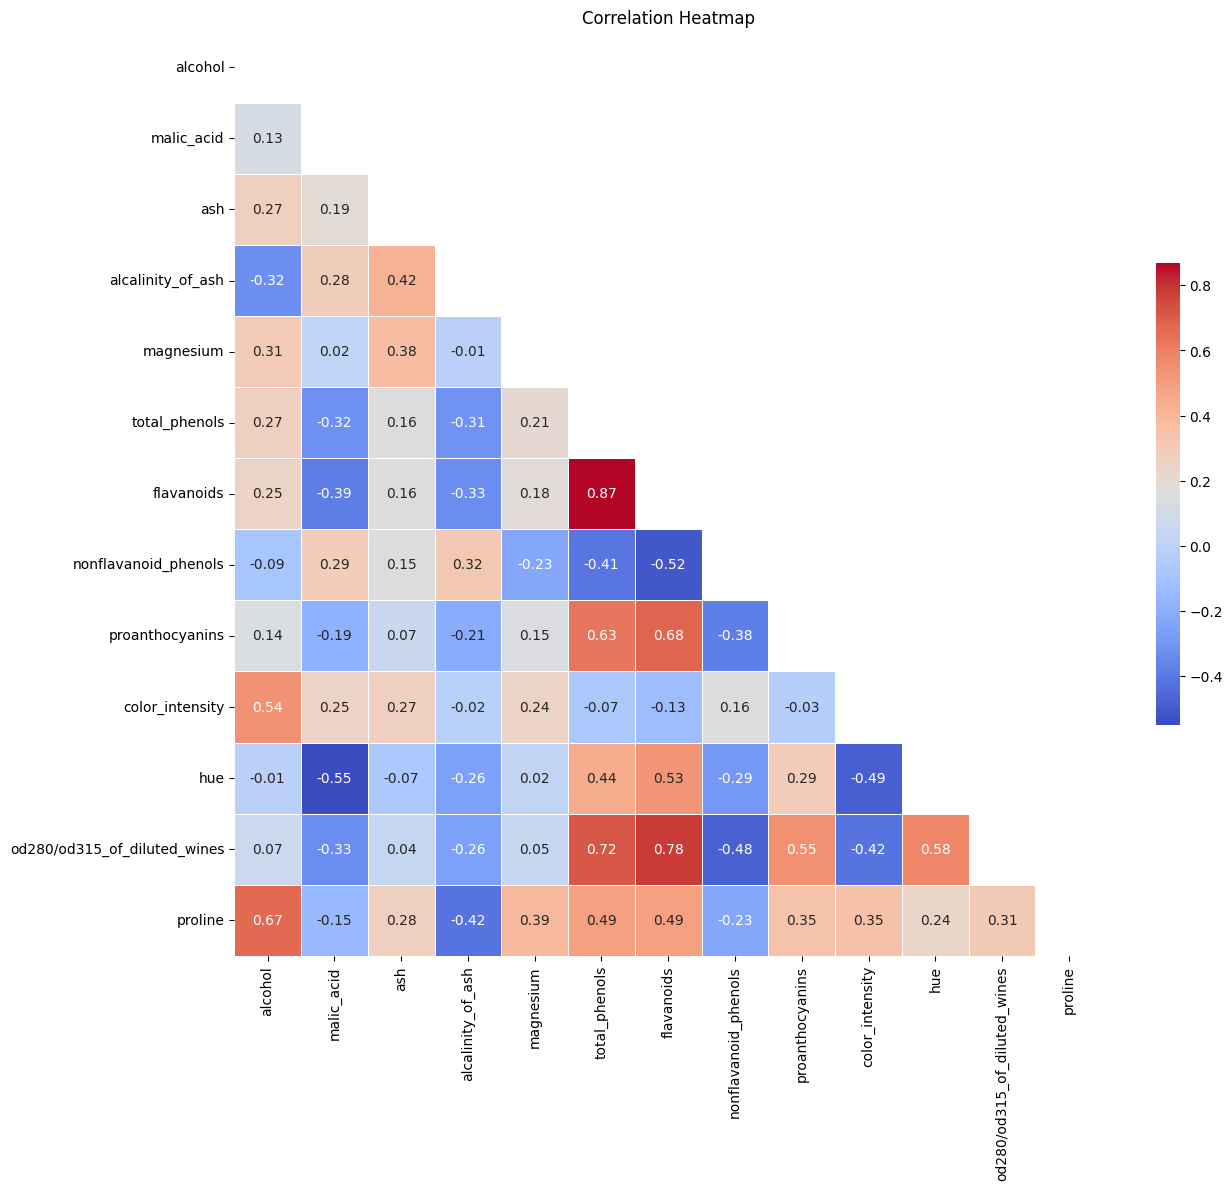

In [122]:
# Exclude 'target' from correlation matrix
features = train_data.drop('target', axis=1)
corr_matrix = features.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(14, 12))

# Draw the heatmap with the mask 
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap='coolwarm',
    annot=True,
    fmt='.2f',
    linewidths=0.5,
    cbar_kws={"shrink": .5},
    xticklabels=corr_matrix.columns,
    yticklabels=corr_matrix.columns
)

# Add title and labels
plt.title('Correlation Heatmap')
plt.show()

In [123]:
# After finiding high correlation between some features - 
# checking the importance of each to consider removing some later on

# Prepare Data
X = train_data.drop('target', axis=1)
y = train_data['target']

# Train model
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Get feature importances
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False, inplace=True)
print(feature_importances)

flavanoids                      0.174964
proline                         0.170508
color_intensity                 0.151043
alcohol                         0.136540
od280/od315_of_diluted_wines    0.095440
hue                             0.091282
total_phenols                   0.046030
magnesium                       0.030347
malic_acid                      0.030087
proanthocyanins                 0.029855
alcalinity_of_ash               0.023708
ash                             0.011937
nonflavanoid_phenols            0.008258
dtype: float64


#### Counts of Each Class
assessing whether the classes are balanced or imbalanced

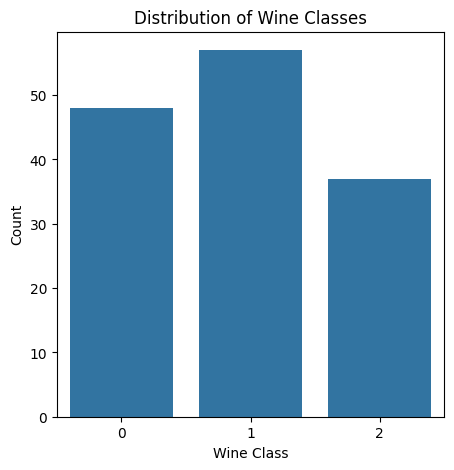

In [124]:
# Set the figure size for the plot
plt.figure(figsize=(5,5))

# Create a count plot for the 'target' variable
sns.countplot(x='target', data=train_data)

# Add a title and labels to the plot
plt.title('Distribution of Wine Classes')
plt.xlabel('Wine Class')
plt.ylabel('Count')

# Display the plot
plt.show()

#### Alcohol Content by Class
compare the distribution of alcohol content among the different wine classes

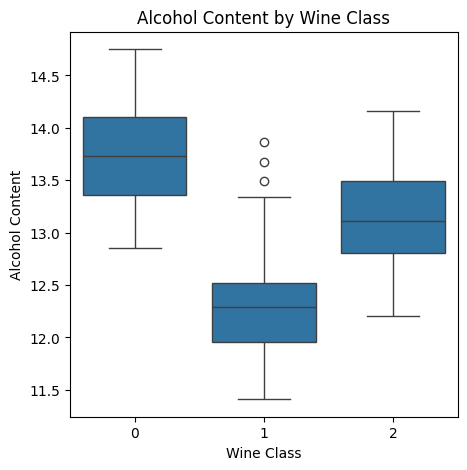

In [125]:
# Boxplot of Alcohol content by Wine Class
plt.figure(figsize=(5,5))
sns.boxplot(x='target', y='alcohol', data=train_data)
plt.title('Alcohol Content by Wine Class')
plt.xlabel('Wine Class')
plt.ylabel('Alcohol Content')
plt.show()

## Part 3 - Experiments
You could add as many code cells as needed

#### Data Preparation


In [126]:
# Separate features and target variable from training data
X_train = train_data.drop('target', axis=1)
y_train = train_data['target']

#### Feature Engineering


In [127]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Create a pipeline for combining different feature engineering techniques
# The pipeline allows us to apply multiple transformations sequentially

# 1. StandardScaler for normalization
# 2. PolynomialFeatures to add interactions and higher-degree terms (degree=2 in this case)
# 3. PCA for dimensionality reduction, keeping 95% of the variance
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalization step
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),  # Adding polynomial features
    ('pca', PCA(n_components=0.95))  # Dimensionality reduction step, keeping 95% of variance
])

# Apply the pipeline to the training data
X_transformed = pipeline.fit_transform(X_train)
print(f'Transformed shape: {X_transformed.shape}')


Transformed shape: (142, 39)


#### Grid Search with Cross-Validation

In [168]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier

# Define models and parameters

models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
}

# Define hyperparameters for each model
param_grid = {
    # Logistic Regression hyperparameters
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength: smaller values specify stronger regularization
        'solver': ['liblinear', 'lbfgs', 'saga'],  # Different solvers to optimize the logistic function
        'max_iter': [100, 200, 500]  # Maximum number of iterations for solver convergence
    },
    
    # Random Forest hyperparameters
    'Random Forest': {
        'n_estimators': [50, 100, 200, 500],  # Number of trees in the forest
        'max_depth': [None, 10, 20, 30],  # Maximum depth of each tree
        'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
        'bootstrap': [True, False]  # Whether to use bootstrap samples when building trees
    },
    
    # K-Nearest Neighbors hyperparameters
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11],  # Number of neighbors to consider (k)
        'weights': ['uniform', 'distance'],  # Weight function used in prediction (uniform: equal, distance: weighted)
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm to compute the nearest neighbors
        'p': [1, 2]  # Power parameter for the Minkowski metric (p=1: Manhattan, p=2: Euclidean)
    }
}

In [171]:
# Define a scorer using macro-average F1 score
scorer = make_scorer(f1_score, average='macro')

# Run Grid Search with 5-fold cross-validation for Random Forest
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(), 
                              param_grid=param_grid['Random Forest'], 
                              scoring=scorer, 
                              cv=5)

grid_search_rf.fit(X_train, y_train)

# Run Grid Search for Logistic Regression
grid_search_lr = GridSearchCV(estimator=LogisticRegression(), 
                              param_grid=param_grid['Logistic Regression'], 
                              scoring=scorer, 
                              cv=5)

grid_search_lr.fit(X_train, y_train)

# Run Grid Search for KNN
grid_search_knn = GridSearchCV(estimator=KNeighborsClassifier(), 
                               param_grid=param_grid['KNN'], 
                               scoring=scorer, 
                               cv=5)

grid_search_knn.fit(X_train, y_train)

# Collect the results into a DataFrame
results = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression', 'KNN'],
    'Best Macro F1 Score': [grid_search_rf.best_score_, grid_search_lr.best_score_, grid_search_knn.best_score_]
})

# Display the results table
print(results)

                 Model  Best Macro F1 Score
0        Random Forest             0.986320
1  Logistic Regression             0.945926
2                  KNN             0.744289


## Part 4 - Training 
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 3)

In [158]:
# Find the model with the highest score
best_model_idx = results_df['Best Score'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_model_params = results_df.loc[best_model_idx, 'Best Params']

print(f"Best Model: {best_model_name}")
print(f"Best Parameters: {best_model_params}")

Best Model: Random Forest
Best Parameters: {'max_depth': None, 'n_estimators': 100, 'random_state': 42}


#### Retrain With The Best Model

In [173]:
X = train_data.drop(columns=['target'])
y = train_data.target

# Use the pipeline from before
X_train_transformed = pipeline.fit_transform(X)  

print(f"Transformed train shape: {X_train_transformed.shape}")

Transformed train shape: (142, 39)


In [174]:
# Retrain the best model on the full training set
if best_model_name == 'Random Forest':
    best_model = RandomForestClassifier(**best_model_params)
elif best_model_name == 'Logistic Regression':
    best_model = LogisticRegression(**best_model_params)
elif best_model_name == 'KNN':
    best_model = KNeighborsClassifier(**best_model_params)

# Train the best model on the transformed train data
best_model.fit(X_train_transformed, y)

RandomForestClassifier(random_state=42)

## Part 5 - Apply on test and show model performance estimation

In [180]:
# Predict on the transformed test set
y_test_pred = best_model.predict(X_test_transformed)

# Show the first 5 predictions along with actual labels
print("First 5 Predictions vs Actual Labels:")
for i in range(5):
    print(f"Prediction: {y_test_pred[i]}, Actual: {y_test.iloc[i]}")

# Evaluate the model on the test set using the macro-average F1 score
f1_test = f1_score(y_test, y_test_pred, average='macro')
print(f'\nMacro F1 Score on the Test Set: {f1_test:.2f}')

First 5 Predictions vs Actual Labels:
Prediction: 2, Actual: 2
Prediction: 0, Actual: 0
Prediction: 2, Actual: 2
Prediction: 1, Actual: 1
Prediction: 2, Actual: 2

Macro F1 Score on the Test Set: 1.00


In [178]:
# Generate a classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        11

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



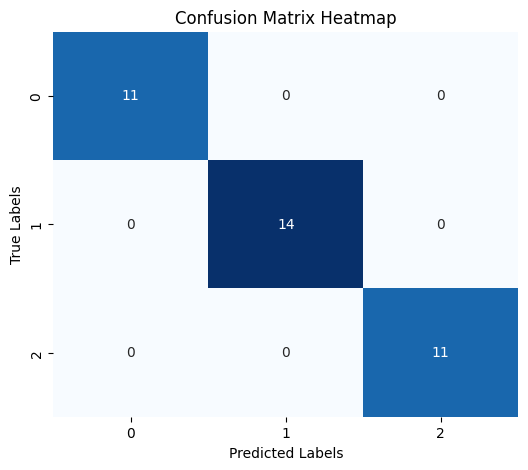

In [179]:
# Generate and plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()